# spaCyを用いた固有表現認識器の学習と評価

このノートブックでは、spaCyのコマンドラインを用いて、固有表現認識モデルの学習と評価をする方法を紹介します。データセットとしては、CoNLL 2003を使います。

## 準備

### インストール

In [1]:
!pip install -q spacy==3.1.2

     |████████████████████████████████| 5.8 MB 2.4 MB/s 
     |████████████████████████████████| 10.1 MB 56.3 MB/s 
     |████████████████████████████████| 456 kB 90.5 MB/s 
     |████████████████████████████████| 42 kB 1.9 MB/s 
     |████████████████████████████████| 623 kB 86.9 MB/s 


### データのアップロード

まずはCoNLLのデータセットをアップロードします。ノートブックと同じ階層にDataフォルダがあり、その下にconll2003/enフォルダがあるので、学習・検証・テスト用データセットをアップロードしましょう。Colabでない場合は、データセットを読み込むときに正しいパスを指定します。

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt
Saving valid.txt to valid.txt


## データをspaCyの形式へ変換

まずはデータをspaCyの形式へ変換しましょう。変換結果を格納する`spacyNER_data`フォルダを作ったあと、spaCyの[convert](https://spacy.io/api/cli#convert)コマンドを使って、データを[DocBin](https://spacy.io/api/docbin)形式へ変換します。このコマンドは、デフォルトではバイナリの`.spacy`ファイルを生成します。



In [3]:
!mkdir spacyNER_data
!python3 -m spacy convert "train.txt" spacyNER_data -c conll
!python3 -m spacy convert "test.txt" spacyNER_data -c conll
!python3 -m spacy convert "valid.txt" spacyNER_data -c conll
# !python3 -m spacy convert "Data/conll2003/en/train.txt" spacyNER_data -c conll
# !python3 -m spacy convert "Data/conll2003/en/test.txt" spacyNER_data -c conll
# !python3 -m spacy convert "Data/conll2003/en/valid.txt" spacyNER_data -c conll

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (14987 documents):
spacyNER_data/train.spacy
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (3684 documents): spacyNER_data/test.spacy
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (3466 documents): spacyNER_data/valid.spacy


## 設定ファイルの作成

学習を始める前に、学習するモデルの設定を記述した設定ファイルを用意する必要があります。自分で全てを書くのは大変ですが、[spaCyのサイト](https://spacy.io/usage/training#quickstart)から設定ファイルを生成できます。

- https://spacy.io/usage/training#quickstart

言語として「English」、コンポーネントとして「ner」にチェックを付けたら、コピーして保存しましょう。

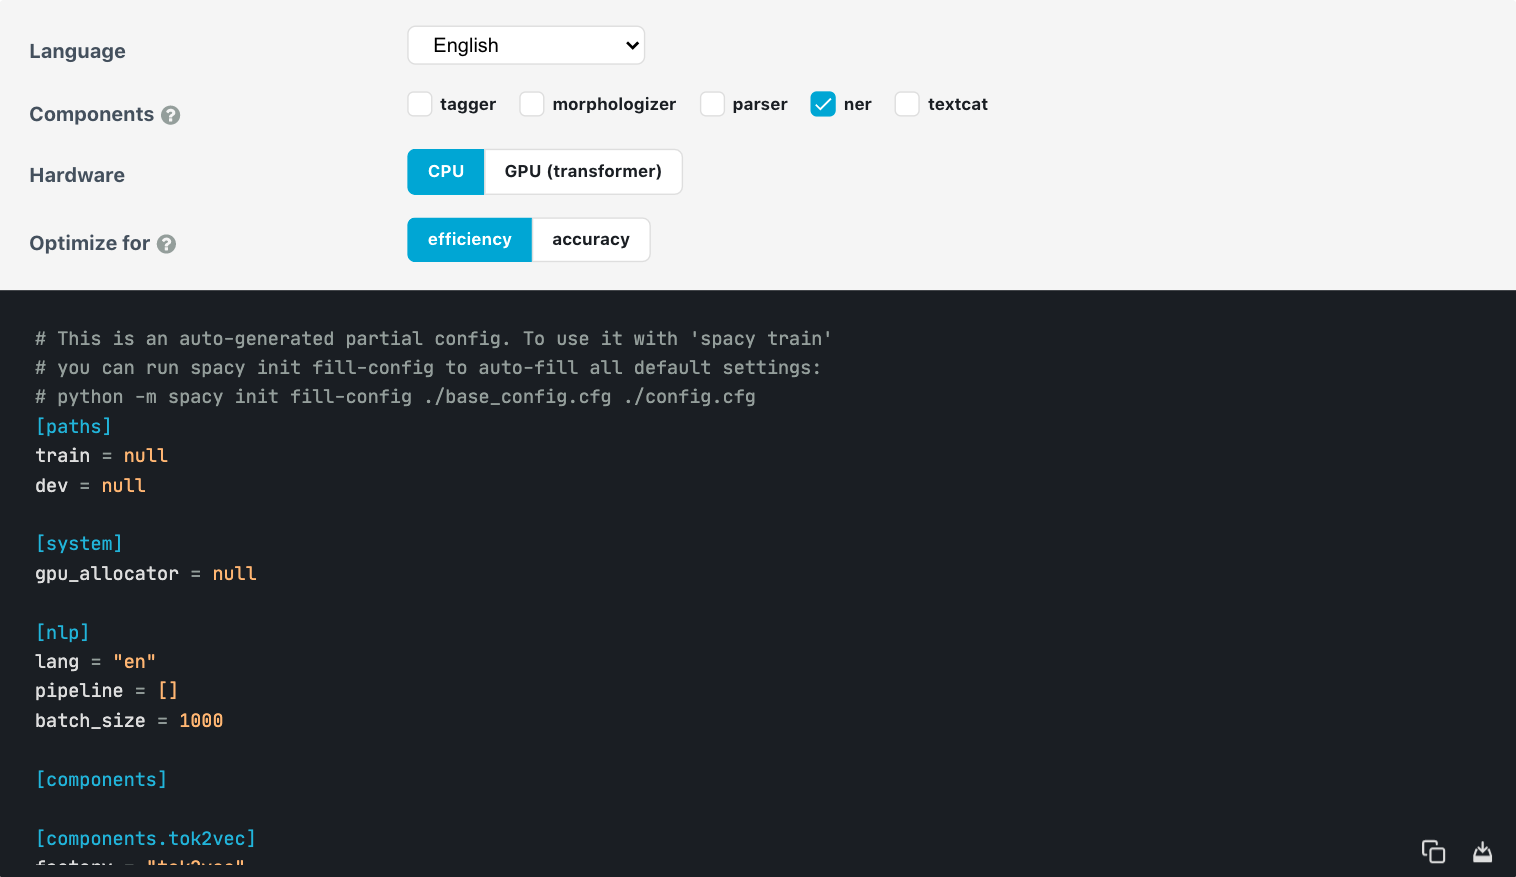


以下では、上記の画面の設定で生成した設定ファイルを`base_config.cfg`に書き込んでいます。

In [4]:
%%writefile base_config.cfg
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null

[system]
gpu_allocator = null

[nlp]
lang = "en"
pipeline = ["tok2vec","ner"]
batch_size = 1000

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["ORTH", "SHAPE"]
rows = [5000, 2500]
include_static_vectors = false

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 96
depth = 4
window_size = 1
maxout_pieces = 3

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}

Writing base_config.cfg


`base_config.cfg`を保存したら、`init fill-config`コマンドを使って、設定していない項目をデフォルト値で埋めます。こうすることで、暗黙的なデフォルト値が存在しないようにします。こうして作成した学習用の設定は、実験の再現性を保つために役に立ちます。

In [5]:
!python -m spacy init fill-config base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


## spaCyのCLIを使ってモデルを学習

データを準備できたので、spacyのtrainコマンドを使って、英語（en）を対象にモデルを学習します。学習結果は`model`というフォルダに格納することにしましょう。データのパスは設定ファイルの`[paths]`セクションに含めることもできますが、今回はコマンドラインから渡すことにしましょう。その他のコマンドラインオプションは https://spacy.io/api/cli#train で確認できます。

In [6]:
!python -m spacy train config.cfg --output=./model --paths.train spacyNER_data/train.spacy --paths.dev spacyNER_data/valid.spacy

✔ Created output directory: model
ℹ Saving to output directory: model
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2021-09-20 01:33:35,137] [INFO] Set up nlp object from config
[2021-09-20 01:33:35,147] [INFO] Pipeline: ['tok2vec', 'ner']
[2021-09-20 01:33:35,151] [INFO] Created vocabulary
[2021-09-20 01:33:35,152] [INFO] Finished initializing nlp object
[2021-09-20 01:33:52,965] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     50.06    0.07    0.09    0.05    0.00
  0     200        155.78   3250.90   51.50   53.06   50.03    0.52
  0     400        290.04   2311.47   66.48   67.84   65.18    0.66
  0     60

学習が終わると、指定したディレクトリにモデルが保存されます。学習中に表示される項目は以下の通りです。

1. `#`は最適化ステップ数
2. `LOSS NER`はモデルの損失
3. `ENTS_F`、`ENTS_P`、`ENTS_R`はF値、適合率、再現率

## モデルの評価

モデルの学習を終えたので、テストデータ（`spacyNER_data/test.spacy`）を使って、モデルの性能を評価しましょう。評価には、spaCyの`evaluate`コマンドを使います。このコマンドに、学習したモデルとテストデータを渡すことで性能を評価できます。

In [7]:
!python -m spacy evaluate model/model-best spacyNER_data/test.spacy

ℹ Using CPU

================================== Results ==================================

TOK     -    
NER P   80.17
NER R   80.29
NER F   80.23
SPEED   28661


=============================== NER (per type) ===============================

           P       R       F
PER    80.55   82.19   81.36
MISC   72.34   75.64   73.96
LOC    82.90   86.03   84.44
ORG    80.42   74.65   77.43



## 学習したモデルを使った予測

学習を終えたら、モデルを読み込み、spaCyのモデルと同じようにして予測することができます。モデルを使って予測し、予測結果を`displacy`を使って可視化しましょう。

In [8]:
import spacy

nlp = spacy.load("./model/model-best")
doc = nlp("Japan is an island country in East Asia, located in the northwest Pacific Ocean.")
spacy.displacy.render(doc, style="ent", jupyter=True)